# Project: Predicting Contact Lens Lot Output via Batch-Level Modeling

## 1. Introduction

This project focuses on accurately predicting the final output count (number of passed lenses) for a production lot in contact lens manufacturing. It demonstrates the superiority of using granular batch-level data compared to aggregated lot-level features and utilizes a tuned Random Forest model to achieve high prediction accuracy (R² > 0.9). The goal is to provide a tool that enables better inventory withdrawal planning based on predicted lot yields.



## 2. Setup

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignore specific warnings if desired (like FutureWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

print("Libraries imported and Google Drive mounted.")

Mounted at /content/drive
Libraries imported and Google Drive mounted.


## 3. Data Simulation & Preparation (Batch Level)

This section simulates the batch-level data required for the analysis. It generates individual batch records with features like storage duration, power, QC results, and pass/fail counts, then groups them into lots ensuring consistency. The output is `batches_df_complete`.

In [3]:
print("--- Preparing Batch-Level Data with Lot IDs ---")

# --- Configuration ---
N_BATCHES_TOTAL = 6000 # Use same number as before for consistency
LOT_SIZE = 6
if N_BATCHES_TOTAL % 6 != 0:
    print("Warning: N_BATCHES_TOTAL should be a multiple of 6.")

print(f"Simulating {N_BATCHES_TOTAL} batches...")

# --- A. Simulate Batch Data ---
print("\nStep A: Simulating individual batch data...")
batch_ids = [f'B{30000 + i:05d}' for i in range(N_BATCHES_TOTAL)]
mould_lines = np.random.choice([1, 2, 3], N_BATCHES_TOTAL, p=[0.3, 0.3, 0.4])

# Define possible powers
possible_powers = np.round(np.arange(-10.00, 6.00 + 0.25, 0.25), 2)
print(f"  Defined {len(possible_powers)} possible power levels.")
target_lens_powers = np.random.choice(possible_powers, N_BATCHES_TOTAL)

# Simulate Monomer Lot Number
monomer_lots = np.random.choice(['MONO_LOT_A1', 'MONO_LOT_A2', 'MONO_LOT_B1', 'MONO_LOT_C1'], N_BATCHES_TOTAL, p=[0.4, 0.3, 0.2, 0.1])

# Simulate dates and Storage Duration
start_date = datetime(2022, 1, 1)
mould_dates_list = [start_date + timedelta(days=int(d)) for d in np.random.randint(0, 365*2, N_BATCHES_TOTAL)]
filling_dates_list = [d + timedelta(days=np.random.randint(2, 5)) for d in mould_dates_list]
warehouse_entry_dates_list = filling_dates_list

storage_days_long = np.random.randint(181, 450, int(N_BATCHES_TOTAL * 0.25)) # ~25% long
storage_days_short = np.random.randint(10, 181, int(N_BATCHES_TOTAL * 0.75))
storage_days_array = np.concatenate([storage_days_long, storage_days_short])
np.random.shuffle(storage_days_array)
delensing_dates_list = [d + timedelta(days=int(s)) for d, s in zip(warehouse_entry_dates_list, storage_days_array)]
storage_duration_days = storage_days_array

# Simulate QC Results
mould_qc_fail_prob = 0.03 + (mould_lines == 3) * 0.04
mould_qc_results = np.array(['Fail' if np.random.rand() < p else 'Pass' for p in mould_qc_fail_prob])
filling_qc_fail_prob = 0.04 + (mould_qc_results == 'Fail') * 0.06
filling_qc_results = np.array(['Fail' if np.random.rand() < p else 'Pass' for p in filling_qc_fail_prob])

# Simulate Mould In Count
mould_in_counts = np.random.randint(2000, 2501, N_BATCHES_TOTAL)

# Simulate Pass/Fail Count per Batch
base_fail_rate = 0.15
storage_penalty = (storage_days_array > 180) * 0.10
power_penalty = ((target_lens_powers <= 0) & (target_lens_powers >= -2.50)) * 0.05
mould_qc_penalty = (mould_qc_results == 'Fail') * 0.05
filling_qc_penalty = (filling_qc_results == 'Fail') * 0.05
random_noise = np.random.normal(0, 0.02, N_BATCHES_TOTAL)
batch_fail_prob = base_fail_rate + storage_penalty + power_penalty + mould_qc_penalty + filling_qc_penalty + random_noise
batch_fail_prob = np.clip(batch_fail_prob, 0.05, 0.30) # Corresponds to 70-95% yield
batch_lens_fail_counts = (mould_in_counts * batch_fail_prob).astype(int)
batch_lens_pass_counts = mould_in_counts - batch_lens_fail_counts

# Assemble Batch DataFrame (Include all relevant batch features)
batches_df = pd.DataFrame({
    'Detailed_Batch_ID': batch_ids,
    'Power': target_lens_powers,
    'Mould_Line': mould_lines,
    #'Mould_Date': mould_dates_list, # Keep dates if needed as features
    #'Filling_Date': filling_dates_list,
    'Warehouse_Entry_Date': warehouse_entry_dates_list,
    #'Delensing_Date': delensing_dates_list,
    'Storage_Duration_Days': storage_duration_days,
    'Mould_Dimension_QC_Result': mould_qc_results,
    'Filling_QC_Result': filling_qc_results,
    'Monomer_Lot_Number': monomer_lots,
    'Mould_In_Count': mould_in_counts,
    'Lens_Pass_Count': batch_lens_pass_counts, # This will be our target y
    'Lens_Fail_Count': batch_lens_fail_counts
    # Add other simulated batch features if needed (temps, pressures etc.)
})
print(f"  Simulated {len(batches_df)} batches.")

# --- B. Group Batches into Lots ---
print("\nStep B: Grouping batches into lots (size 6, same power)...")
batches_df = batches_df.sort_values(by=['Power', 'Warehouse_Entry_Date'])
batches_df['Lot_Group_Index'] = batches_df.groupby('Power').cumcount() // LOT_SIZE
batches_df['Lot_ID'] = batches_df['Power'].astype(str) + '_' + batches_df['Lot_Group_Index'].astype(str)

lot_sizes = batches_df['Lot_ID'].value_counts()
complete_lots = lot_sizes[lot_sizes == LOT_SIZE].index
batches_df_complete = batches_df[batches_df['Lot_ID'].isin(complete_lots)].copy() # Use .copy() to avoid SettingWithCopyWarning later
N_LOTS_ACTUAL = len(complete_lots)
print(f"  Created {N_LOTS_ACTUAL} complete lots.")

print("\n--- Batch-Level Data Ready ---")
print(f"DataFrame 'batches_df_complete' shape: {batches_df_complete.shape}")
print("Columns available:", batches_df_complete.columns.tolist())
print(batches_df_complete.head())

--- Preparing Batch-Level Data with Lot IDs ---
Simulating 6000 batches...

Step A: Simulating individual batch data...
  Defined 65 possible power levels.
  Simulated 6000 batches.

Step B: Grouping batches into lots (size 6, same power)...
  Created 971 complete lots.

--- Batch-Level Data Ready ---
DataFrame 'batches_df_complete' shape: (5826, 13)
Columns available: ['Detailed_Batch_ID', 'Power', 'Mould_Line', 'Warehouse_Entry_Date', 'Storage_Duration_Days', 'Mould_Dimension_QC_Result', 'Filling_QC_Result', 'Monomer_Lot_Number', 'Mould_In_Count', 'Lens_Pass_Count', 'Lens_Fail_Count', 'Lot_Group_Index', 'Lot_ID']
     Detailed_Batch_ID  Power  Mould_Line Warehouse_Entry_Date  \
3799            B33799  -10.0           3           2022-01-03   
4680            B34680  -10.0           1           2022-01-04   
1152            B31152  -10.0           2           2022-01-07   
5595            B35595  -10.0           3           2022-01-07   
3609            B33609  -10.0           3      

## 4. Exploratory Data Analysis (EDA) - Batch Level

In this section, we'll explore the simulated batch-level data (`batches_df_complete`) to understand the distributions of key features and their relationship with the target variable (`Lens_Pass_Count`).

1) We'll look at the distributions of important numerical features like storage duration, the number of moulds input, and the lens power. We're using histograms and box plots.

--- EDA: Distributions of Key Numerical Features ---


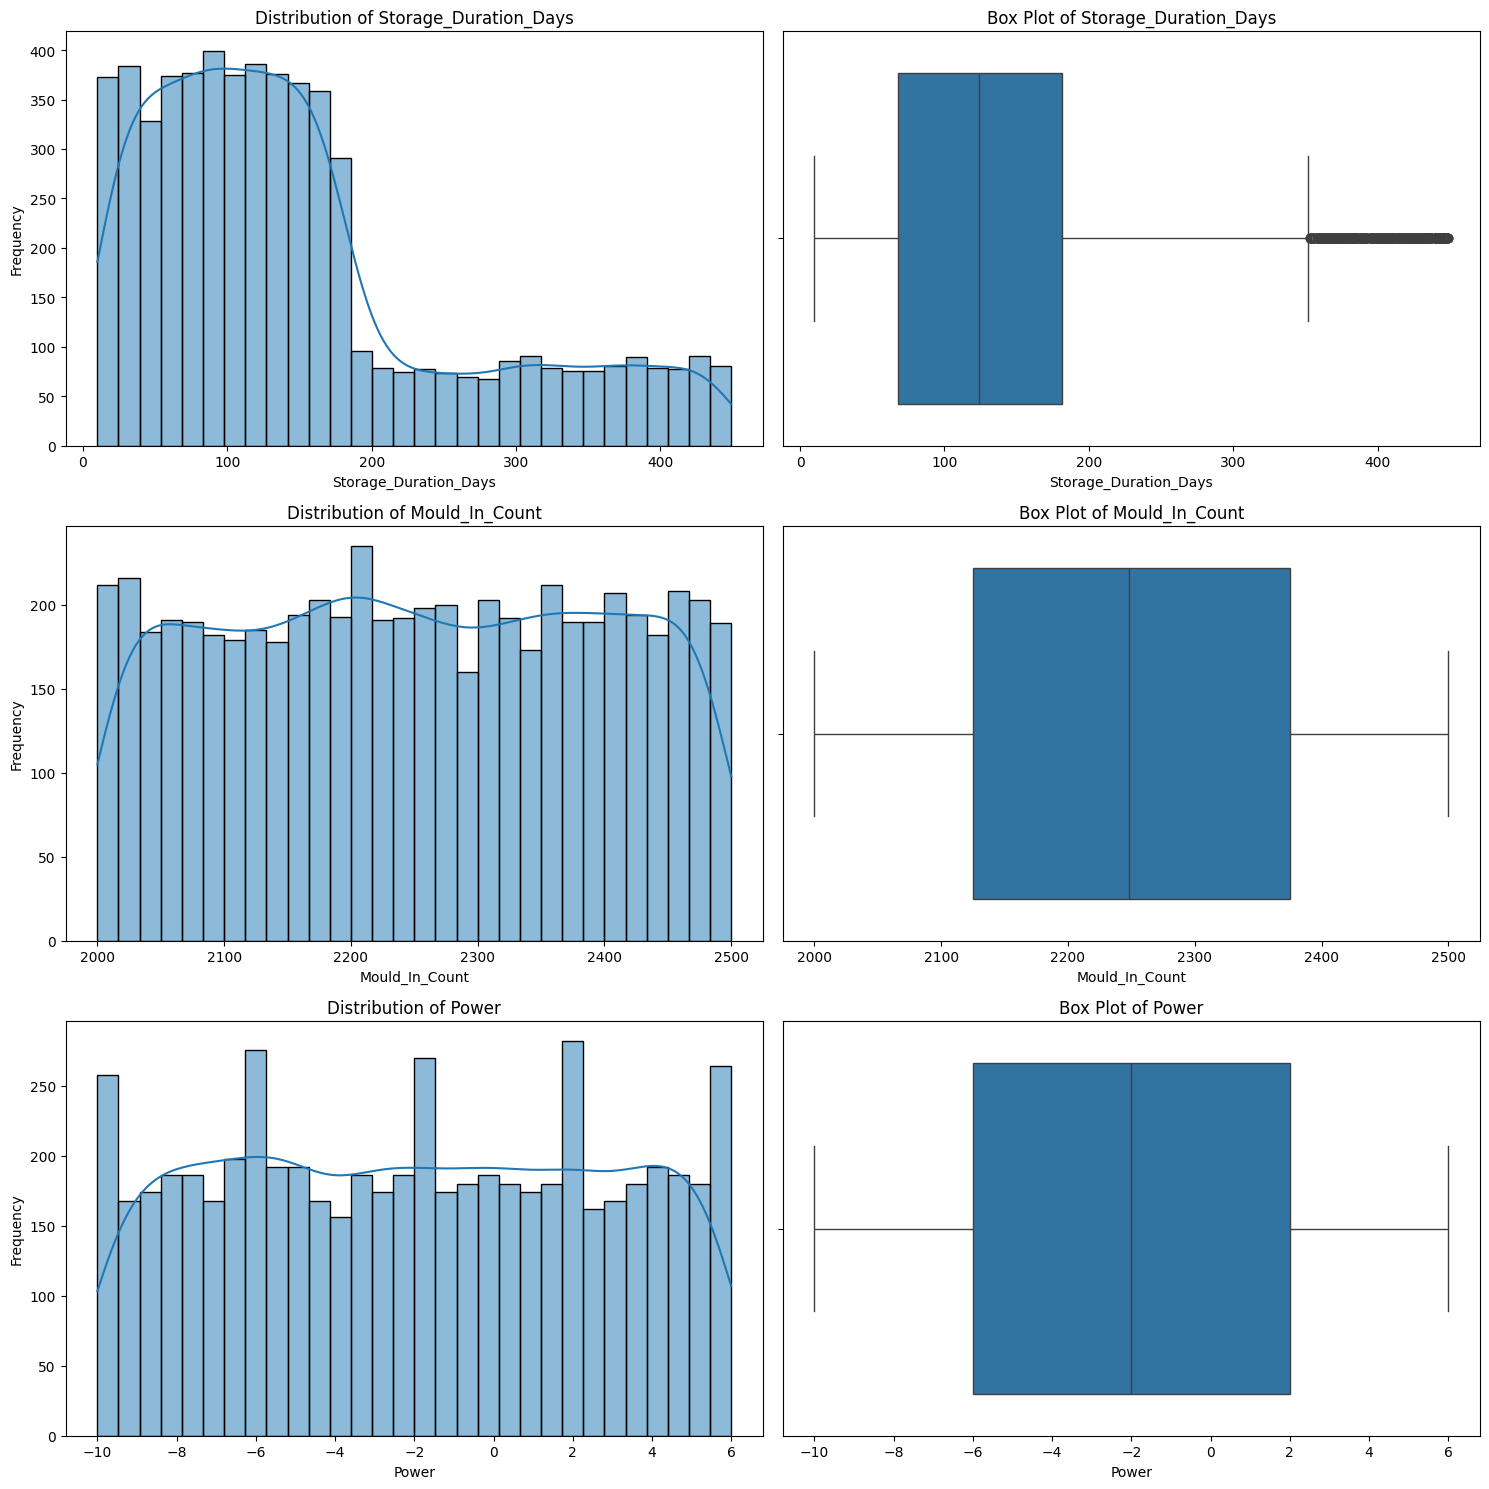


Descriptive Statistics for Key Numerical Features:
       Storage_Duration_Days  Mould_In_Count        Power
count            5826.000000     5826.000000  5826.000000
mean              150.995709     2249.841744    -1.989444
std               111.663794      145.064934     4.684042
min                10.000000     2000.000000   -10.000000
25%                68.000000     2125.000000    -6.000000
50%               124.000000     2248.000000    -2.000000
75%               181.750000     2375.000000     2.000000
max               449.000000     2500.000000     6.000000


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is available

# Ensure batches_df_complete exists
if 'batches_df_complete' not in locals() or not isinstance(batches_df_complete, pd.DataFrame):
    raise NameError("DataFrame 'batches_df_complete' not found. Please run the simulation cell first.")

print("--- EDA: Distributions of Key Numerical Features ---")

# Select key numerical features to plot
numerical_features = ['Storage_Duration_Days', 'Mould_In_Count', 'Power']

# Create plots
plt.figure(figsize=(15, 5 * len(numerical_features))) # Adjust height based on number of features

for i, col in enumerate(numerical_features):
    if col not in batches_df_complete.columns:
        print(f"Warning: Column '{col}' not found, skipping plots.")
        continue

    # Histogram
    plt.subplot(len(numerical_features), 2, 2*i + 1) # Position for histogram
    sns.histplot(data=batches_df_complete, x=col, kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Box Plot
    plt.subplot(len(numerical_features), 2, 2*i + 2) # Position for box plot
    sns.boxplot(data=batches_df_complete, x=col)
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# Print descriptive statistics
print("\nDescriptive Statistics for Key Numerical Features:")
print(batches_df_complete[numerical_features].describe())

**Storage_Duration_Days**:

What it shows: How storage times are distributed across all simulated batches.

Pattern: We simulated ~75% short (<181 days) and ~25% long (>180 days) storage. The histogram look skewed right, with a large peak for shorter durations and a smaller bump or tail for longer durations. The box plot show the overall duration range (e.g., ~10 to ~450 days) and the median is falling in the shorter duration range

**Mould_In_Count**:

What it shows: The distribution of starting mould counts per batch.

Pattern: We simulated this uniformly between 2000 and 2500. The histogram look relatively flat across that range. The box plot span roughly 2000-2500

**Power**:

What it shows: The distribution of lens powers assigned to batches.

Pattern: We chose randomly from a list of possible powers (-10 to +6). The histogram show roughly similar counts for each possible power level, though there is a random variation

2) We'll examine the frequency of different categories for important categorical features like Mould Line and the upstream QC results. We use count plots (bar charts).


--- EDA: Distributions of Key Categorical Features ---


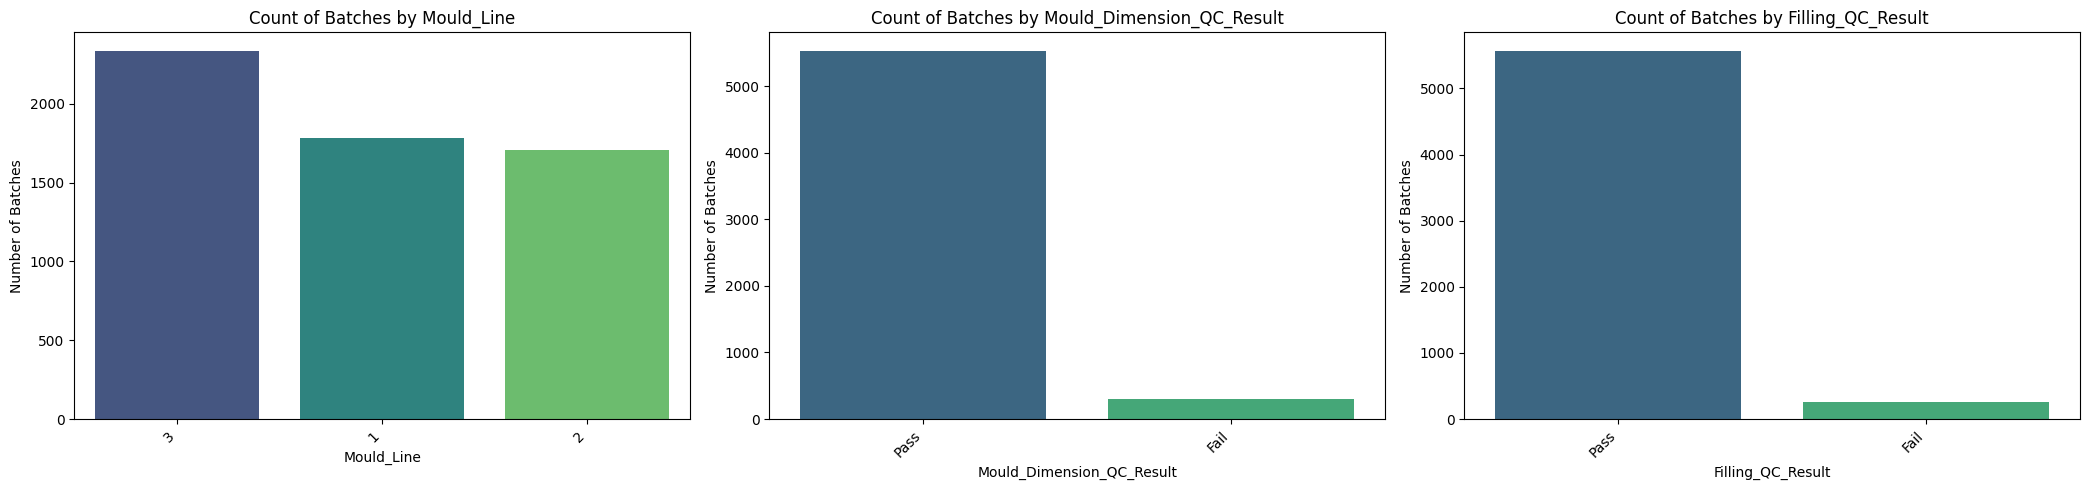

In [5]:
print("\n--- EDA: Distributions of Key Categorical Features ---")

# Select key categorical features
# Note: Ensure these columns exist after simulation
categorical_features = ['Mould_Line', 'Mould_Dimension_QC_Result', 'Filling_QC_Result']

# Check which features actually exist in the dataframe
existing_categorical = [f for f in categorical_features if f in batches_df_complete.columns]

if not existing_categorical:
    print("No specified categorical features found to plot.")
else:
    plt.figure(figsize=(7 * len(existing_categorical), 5)) # Adjust width based on number of plots

    for i, col in enumerate(existing_categorical):
        plt.subplot(1, len(existing_categorical), i + 1) # Arrange plots horizontally
        # Create a count plot using Seaborn
        sns.countplot(data=batches_df_complete, x=col, order=batches_df_complete[col].value_counts().index, palette='viridis')
        plt.title(f'Count of Batches by {col}')
        plt.xlabel(col)
        plt.ylabel('Number of Batches')
        plt.xticks(rotation=45, ha='right') # Rotate labels if needed

    plt.tight_layout()
    plt.show()

**Mould_Line**:

What it shows: How many batches came
from each moulding line.

Pattern: Line 3 have slightly more batches (around 40% of total) than Line 1 and Line 2 (around 30% each), reflecting the p=[0.3, 0.3, 0.4] probability we used.

**Mould_Dimension_QC_Result / Filling_QC_Result:**

What it shows: The number of batches passing vs. failing upstream QC.

Pattern: The 'Pass' bar should be significantly higher than the 'Fail' bar, as we simulated low base failure rates (e.g., 3-4% plus small conditional increases)

3) We'll explore how some of the key features relate to our target variable, `Lens_Pass_Count`. We'll use scatter plots for numerical features and box plots for categorical features.


--- EDA: Relationships Between Features and Target (Lens_Pass_Count) ---

Plotting Numerical Features vs. Target...


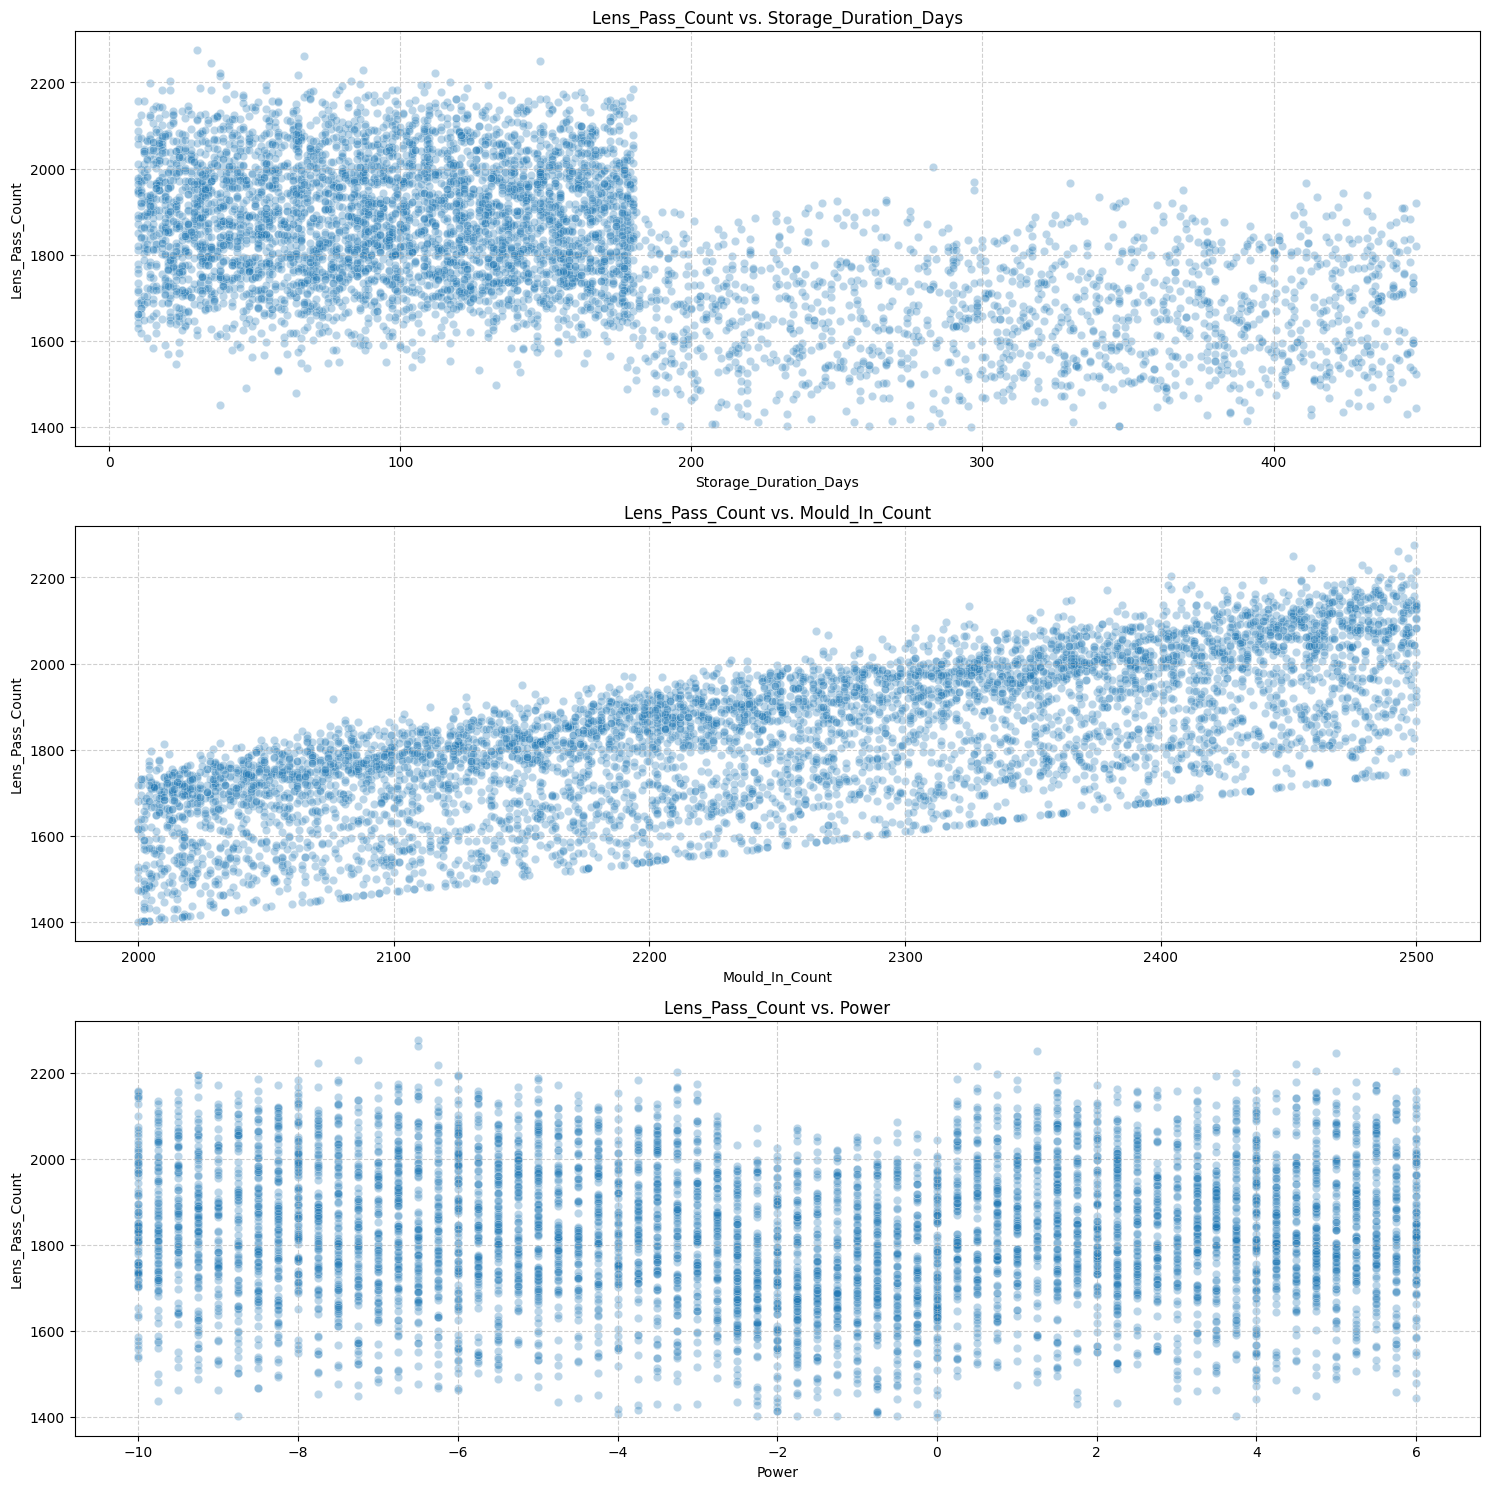


Plotting Categorical Features vs. Target...


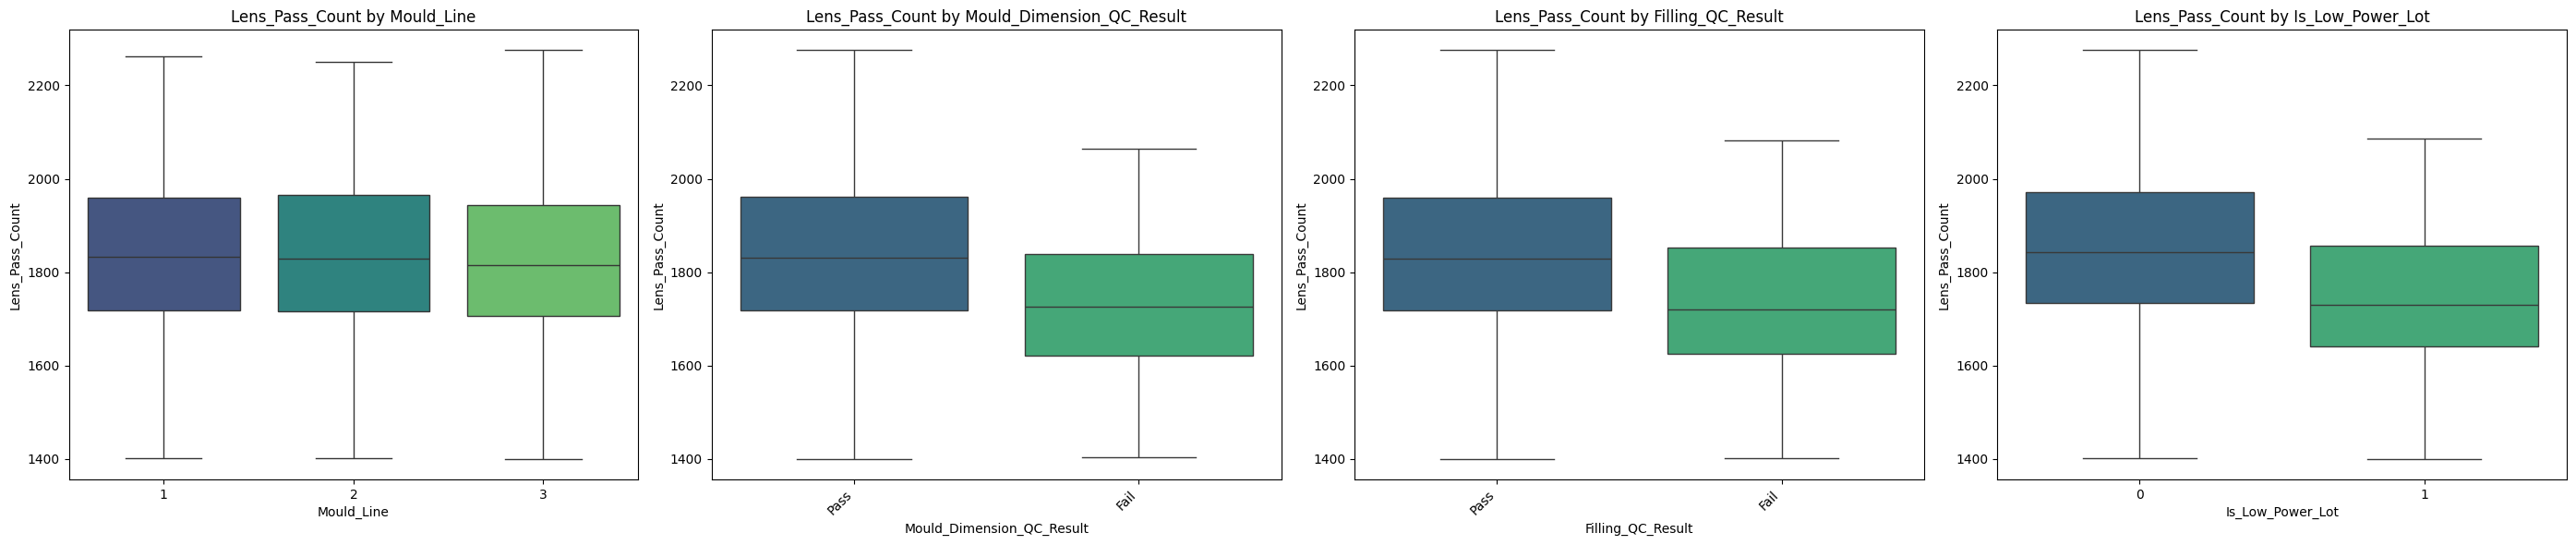

In [7]:
print("\n--- EDA: Relationships Between Features and Target (Lens_Pass_Count) ---")

TARGET_BATCH = 'Lens_Pass_Count'
if TARGET_BATCH not in batches_df_complete.columns:
     raise KeyError(f"Target column '{TARGET_BATCH}' not found.")


# --- Numerical Features vs Target ---
numerical_vs_target = ['Storage_Duration_Days', 'Mould_In_Count', 'Power']
print("\nPlotting Numerical Features vs. Target...")
plt.figure(figsize=(15, 5 * len(numerical_vs_target)))

for i, col in enumerate(numerical_vs_target):
     if col not in batches_df_complete.columns: continue # Skip if column missing
     plt.subplot(len(numerical_vs_target), 1, i + 1) # Stack plots vertically
     # Use scatter plot
     sns.scatterplot(data=batches_df_complete, x=col, y=TARGET_BATCH, alpha=0.3) # alpha for density
     plt.title(f'{TARGET_BATCH} vs. {col}')
     plt.xlabel(col)
     plt.ylabel(TARGET_BATCH)
     plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- Categorical Features vs Target ---
categorical_vs_target = ['Mould_Line', 'Mould_Dimension_QC_Result', 'Filling_QC_Result', 'Is_Low_Power_Lot'] # Add Is_Low_Power_Lot if created
# Create Is_Low_Power_Lot flag if not done during simulation (optional)
if 'Is_Low_Power_Lot' not in batches_df_complete.columns and 'Power' in batches_df_complete.columns:
     print("Creating 'Is_Low_Power_Lot' flag for visualization...")
     batches_df_complete['Is_Low_Power_Lot'] = ((batches_df_complete['Power'] <= 0) & (batches_df_complete['Power'] >= -2.50)).astype(int)
     if 'Is_Low_Power_Lot' not in categorical_vs_target: categorical_vs_target.append('Is_Low_Power_Lot')


print("\nPlotting Categorical Features vs. Target...")
existing_categorical_vs_target = [f for f in categorical_vs_target if f in batches_df_complete.columns]

if not existing_categorical_vs_target:
    print("No specified categorical features found to plot against target.")
else:
    plt.figure(figsize=(7 * len(existing_categorical_vs_target), 6)) # Adjust size

    for i, col in enumerate(existing_categorical_vs_target):
        plt.subplot(1, len(existing_categorical_vs_target), i + 1)
        # Use box plot to see distribution of target for each category
        order = sorted(batches_df_complete[col].unique()) if batches_df_complete[col].dtype != 'object' else batches_df_complete[col].value_counts().index
        sns.boxplot(data=batches_df_complete, x=col, y=TARGET_BATCH, order=order, palette='viridis')
        plt.title(f'{TARGET_BATCH} by {col}')
        plt.xlabel(col)
        plt.ylabel(TARGET_BATCH)
        if batches_df_complete[col].nunique() > 8 or batches_df_complete[col].dtype == 'object': # Rotate labels if many or text
             plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

**Storage_Duration_Days vs. Lens_Pass_Count:**

What it shows: How the number of passed lenses changes as storage time increases.

Pattern: A negative relationship. Points generally trend downwards (lower pass counts) as storage duration increases. There is a noticeable drop or increased downward scatter for points where storage is > 180 days due to the penalty we added in the simulation. Lots of scatter is expected because other factors also affect the pass count.

**Mould_In_Count vs. Lens_Pass_Count:**

What it shows: How the starting number of moulds relates to the final number of passed lenses.

Pattern: A strong positive linear relationship. Points form an upward-sloping band. Batches starting with more moulds result in more passed lenses. The points mostly lie between lines representing 70% and 95% yield (the range we enforced).

**Power vs. Lens_Pass_Count:**
What it shows: How lens power relates to the number of passed lenses.

Pattern: Slightly lower pass counts or more downward scatter specifically for points where the Power is between -2.50 and 0.00, reflecting the penalty we added.

**Mould_Line vs. Lens_Pass_Count:**

What it shows: Compares the distribution of pass counts for batches from each mould line.

Pattern: The box plot for Line 3 show a slightly lower median or a wider spread towards lower pass counts compared to Lines 1 and 2, because Line 3 batches had a slightly higher chance of failing Mould QC in the simulation.

**QC Results (Mould_Dimension_QC_Result, Filling_QC_Result) vs. Lens_Pass_Count:**

What it shows: Compares pass counts for batches that passed upstream QC vs. those that failed.

Pattern: The 'Fail' box for both QC types show significantly lower pass counts (lower median, lower overall distribution) compared to the 'Pass' box.

**Is_Low_Power_Lot vs. Lens_Pass_Count:**

What it shows: Compares pass counts for low-power batches vs. others.

Expected Pattern: The box for category '1' (Low Power: -2.50 to 0.00 D) show a noticeably lower distribution of pass counts than the box for category '0'.


## 5. Data Preprocessing for Batch-Level Model

First, we separate the target variable (`Lens_Pass_Count`) from the potential predictor features at the batch level. Then, to ensure a valid evaluation, we split the data into training and testing sets based on `Lot_ID`, so all batches from a single lot are in the same set.

In [13]:
# Preprocessing Step 1: Define Batch X/y and Split Lot IDs
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

print("\n--- Preparing Batch Data for Model (Approach 2) ---")

# Ensure batches_df_complete exists from the simulation step
if 'batches_df_complete' not in locals() or not isinstance(batches_df_complete, pd.DataFrame):
    raise NameError("DataFrame 'batches_df_complete' not found. Please ensure the simulation cell ran correctly.")

# 1. Define Target and Potential Features at Batch Level
TARGET_BATCH = 'Lens_Pass_Count'
# List columns to drop to get initial feature set (keep Lot_ID for splitting)
cols_to_drop_initial = [
    'Detailed_Batch_ID',
    TARGET_BATCH,
    'Lens_Fail_Count',
    # Drop raw dates as Storage_Duration_Days captures the time effect
    'Mould_Date', 'Filling_Date', 'Warehouse_Entry_Date', 'Delensing_Date'
]
# Ensure we only try to access/drop columns that actually exist
feature_cols_with_id = [col for col in batches_df_complete.columns if col not in cols_to_drop_initial or col == 'Lot_ID']
if TARGET_BATCH in feature_cols_with_id: feature_cols_with_id.remove(TARGET_BATCH) # Make sure target is not in features

print(f"Columns used for splitting (Features + Lot_ID): {feature_cols_with_id}")

X_batch_all_with_id = batches_df_complete[feature_cols_with_id].copy() # Use copy
y_batch_all = batches_df_complete[TARGET_BATCH].copy()

# 2. Split by Lot ID (80% train, 20% test)
print("\nSplitting data by Lot_ID...")
unique_lot_ids = X_batch_all_with_id['Lot_ID'].unique()
# We don't strictly need a validation set just for RF final training/evaluation
train_lot_ids, test_lot_ids = train_test_split(unique_lot_ids, test_size=0.20, random_state=42)

print(f"  Total unique lots: {len(unique_lot_ids)}")
print(f"  Training lots: {len(train_lot_ids)}")
print(f"  Test lots: {len(test_lot_ids)}")

# Keep track of the split Lot IDs (used in the next cell)
print("Lot ID split complete.")


--- Preparing Batch Data for Model (Approach 2) ---
Columns used for splitting (Features + Lot_ID): ['Power', 'Mould_Line', 'Storage_Duration_Days', 'Mould_Dimension_QC_Result', 'Filling_QC_Result', 'Monomer_Lot_Number', 'Mould_In_Count', 'Lot_Group_Index', 'Lot_ID', 'Is_Low_Power_Lot']

Splitting data by Lot_ID...
  Total unique lots: 971
  Training lots: 776
  Test lots: 195
Lot ID split complete.


In [14]:
# Preprocessing Step 2: Create Train/Test DataFrames & Final X/y Separation

print("\nCreating train/test DataFrames based on lot split...")

# Check if split IDs and main dataframe exist
if 'train_lot_ids' not in locals() or 'test_lot_ids' not in locals() or 'batches_df_complete' not in locals():
     raise NameError("Required variables (train_lot_ids, etc.) not found. Run previous cell.")

# Filter the original complete batch dataframe based on the split Lot IDs
train_batch_df = batches_df_complete[batches_df_complete['Lot_ID'].isin(train_lot_ids)].copy()
test_batch_df = batches_df_complete[batches_df_complete['Lot_ID'].isin(test_lot_ids)].copy()

print(f"  Training batches shape: {train_batch_df.shape}")
print(f"  Testing batches shape: {test_batch_df.shape}")

# Optional: Verification check for lot overlap
train_lots_set = set(train_batch_df['Lot_ID'].unique())
test_lots_set = set(test_batch_df['Lot_ID'].unique())
overlap = train_lots_set.intersection(test_lots_set)
if not overlap:
    print("  Verification: No overlap in Lot IDs between train and test sets. Split successful.")
else:
    print(f"  Warning: Overlap found in Lot IDs: {overlap}")


# Separate Final X_train, y_train, X_test, y_test (and drop Lot_ID from X)
print("\nSeparating final X/y for train and test...")
# Ensure TARGET_BATCH and cols_to_drop_initial are defined from previous cell
y_train = train_batch_df[TARGET_BATCH]
final_cols_to_drop = [TARGET_BATCH, 'Lot_ID'] + [col for col in cols_to_drop_initial if col != TARGET_BATCH]
X_train = train_batch_df.drop(columns=[col for col in final_cols_to_drop if col in train_batch_df.columns], errors='ignore')

y_test = test_batch_df[TARGET_BATCH]
# Keep Lot_ID with test set separately for later aggregation
test_lot_ids_mapping = test_batch_df[['Lot_ID']].copy()
X_test = test_batch_df.drop(columns=[col for col in final_cols_to_drop if col in test_batch_df.columns], errors='ignore')


print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print("\nFinal features for batch model (before encoding):")
print(X_train.columns.tolist())


Creating train/test DataFrames based on lot split...
  Training batches shape: (4656, 14)
  Testing batches shape: (1170, 14)
  Verification: No overlap in Lot IDs between train and test sets. Split successful.

Separating final X/y for train and test...
  X_train shape: (4656, 9)
  y_train shape: (4656,)
  X_test shape: (1170, 9)
  y_test shape: (1170,)

Final features for batch model (before encoding):
['Power', 'Mould_Line', 'Storage_Duration_Days', 'Mould_Dimension_QC_Result', 'Filling_QC_Result', 'Monomer_Lot_Number', 'Mould_In_Count', 'Lot_Group_Index', 'Is_Low_Power_Lot']


In [15]:
# Preprocessing Step 3: One-Hot Encode Categorical Features
print("\nApplying One-Hot Encoding...")

# Check if X_train/X_test exist
if 'X_train' not in locals() or 'X_test' not in locals():
     raise NameError("X_train or X_test not found. Run previous cell.")
if not isinstance(X_train, pd.DataFrame) or not isinstance(X_test, pd.DataFrame):
     raise TypeError("X_train/X_test should be Pandas DataFrames before encoding.")

# Identify categorical columns (object dtype + Mould_Line)
categorical_cols_batch = X_train.select_dtypes(include='object').columns.tolist()
if 'Mould_Line' in X_train.select_dtypes(include=np.number).columns:
    if 'Mould_Line' not in categorical_cols_batch:
        categorical_cols_batch.append('Mould_Line')
# Add Power here if you decided to treat it as categorical

print(f"  Categorical columns identified for encoding: {categorical_cols_batch}")

if not categorical_cols_batch:
    print("  No categorical columns needed encoding.")
    X_train_processed = X_train.copy() # Final X_train if no encoding
    X_test_processed = X_test.copy()  # Final X_test if no encoding
else:
    # Apply get_dummies separately
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols_batch, drop_first=True, dtype=int)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols_batch, drop_first=True, dtype=int)

    # Align columns - Crucial!
    print("Aligning columns across datasets after encoding...")
    train_cols = X_train_encoded.columns
    X_test_encoded = X_test_encoded.reindex(columns=train_cols, fill_value=0) # Align test to train

    # Ensure no extra columns in test (can happen with sparse data/categories only in test)
    extra_cols_in_test = list(set(X_test_encoded.columns) - set(train_cols))
    if extra_cols_in_test:
         print(f"  Removing extra columns found only in test set: {extra_cols_in_test}")
         X_test_encoded = X_test_encoded.drop(columns=extra_cols_in_test)


    print(f"\nShapes after encoding: Train={X_train_encoded.shape}, Test={X_test_encoded.shape}")
    if not X_train_encoded.shape[1] == X_test_encoded.shape[1]:
        print("Error: Column count mismatch after encoding and alignment!")
        raise ValueError("Column mismatch after encoding")
    else:
        print("Columns successfully aligned.")

    # Assign final processed features
    X_train = X_train_encoded # Use the encoded version moving forward
    X_test = X_test_encoded  # Use the encoded version moving forward
    # y_train and y_test (targets) remain unchanged

print("\nBatch-level data prepared, split by Lot ID, and encoded.")
print("Ready variables: X_train, X_test, y_train, y_test, test_lot_ids_mapping")
print(f"Final number of features: {X_train.shape[1]}")


Applying One-Hot Encoding...
  Categorical columns identified for encoding: ['Mould_Dimension_QC_Result', 'Filling_QC_Result', 'Monomer_Lot_Number', 'Mould_Line']
Aligning columns across datasets after encoding...

Shapes after encoding: Train=(4656, 12), Test=(1170, 12)
Columns successfully aligned.

Batch-level data prepared, split by Lot ID, and encoded.
Ready variables: X_train, X_test, y_train, y_test, test_lot_ids_mapping
Final number of features: 12


## Stage 6: Model Training (Hyperparameter Tuning) & Evaluation (Lot Level)


We'll perform the hyperparameter tuning using RandomizedSearchCV, identify the best Random Forest model based on that search, make predictions on the test set batches, aggregate those predictions to the lot level, and evaluate the final lot-level performance.


--- Stage 5: Batch RF Hyperparameter Tuning & Lot-Level Evaluation ---
INFO: RandomizedSearch fitting may take several minutes...

Defined parameter distributions for Randomized Search.

Initializing RandomizedSearchCV (n_iter=20, cv=3)...

Starting Randomized Search Fit on batch training data (4656 samples)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Randomized Search finished. Time taken: 140.03 seconds

--- Randomized Search Results (Batch Model) ---
Best Parameters found:
{'max_depth': 25, 'max_features': 1.0, 'min_samples_leaf': 3, 'min_samples_split': 16, 'n_estimators': 413}

Best Mean R2 score during Cross-Validation on Train Set: 0.8420

--- Evaluating Best Tuned Batch Model on Test Set (Aggregated to Lot Level) ---
Predicting on batch test set with best model...
Aggregating tuned batch predictions by Lot ID...

Evaluation of Lot Output Prediction (TUNED Batch RF Model - Approach 2):
  MAE: 101.754
  RMSE: 126.361
  R2 Score: 0.925

Comparison to Untuned B

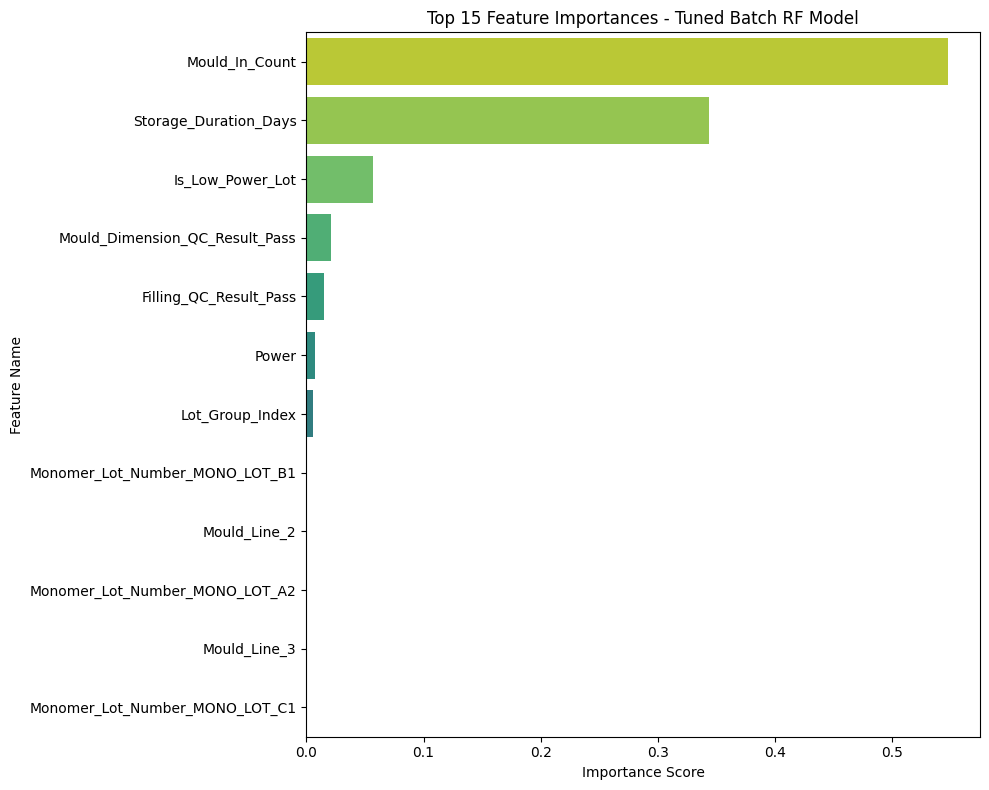

In [11]:
# Stage 6: Model Training (Hyperparameter Tuning) & Evaluation (Lot Level)

print("\n--- Stage 5: Batch RF Hyperparameter Tuning & Lot-Level Evaluation ---")
print("INFO: RandomizedSearch fitting may take several minutes...")

# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import time
from scipy.stats import randint # For sampling integer ranges efficiently
import matplotlib.pyplot as plt # For optional importance plot
import seaborn as sns        # For optional importance plot


# Check if batch-level train/test data exists (should be encoded DataFrames)
if 'X_train' not in locals() or 'X_test' not in locals() or \
   'y_train' not in locals() or 'y_test' not in locals() or \
   'test_lot_ids_mapping' not in locals():
    raise NameError("Required batch-level train/test data or lot mapping not found. Run previous preprocessing cells.")
if not isinstance(X_train, pd.DataFrame) or not isinstance(X_test, pd.DataFrame):
     raise TypeError("X_train/X_test should be DataFrames (after encoding, before scaling) for this RF step.")


# 1. Define Parameter Distribution for Randomized Search
param_dist_batch = {
    'n_estimators': randint(100, 600),
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': randint(5, 21),
    'min_samples_leaf': randint(3, 16),
    'max_features': [1.0, 'sqrt', 'log2'] # 1.0 means consider all features at split
}
print("\nDefined parameter distributions for Randomized Search.")

# 2. Initialize Base Model
rf_batch_base = RandomForestRegressor(random_state=42, n_jobs=-1) # Use all cores for RF

# 3. Initialize RandomizedSearchCV
n_iterations_batch = 20  # Number of combinations to try
cv_folds_batch = 3       # Number of CV folds
print(f"\nInitializing RandomizedSearchCV (n_iter={n_iterations_batch}, cv={cv_folds_batch})...")
random_search = RandomizedSearchCV(
    estimator=rf_batch_base,
    param_distributions=param_dist_batch,
    n_iter=n_iterations_batch,
    cv=cv_folds_batch,
    scoring='r2',     # Optimize for R-squared
    verbose=1,        # Show progress
    random_state=42,
    n_jobs=1          # Let RF handle internal parallelism
)

# 4. Fit RandomizedSearchCV on Batch Training Data
print(f"\nStarting Randomized Search Fit on batch training data ({X_train.shape[0]} samples)...")
start_time = time.time()
random_search.fit(X_train, y_train) # Fit on the encoded batch training data
end_time = time.time()
print(f"Randomized Search finished. Time taken: {(end_time - start_time):.2f} seconds")

# 5. Get Best Parameters and Score from CV
print("\n--- Randomized Search Results (Batch Model) ---")
print("Best Parameters found:")
print(random_search.best_params_)
print(f"\nBest Mean R2 score during Cross-Validation on Train Set: {random_search.best_score_:.4f}")

# 6. Evaluate the Single Best Model found by search on the actual Test Set (Aggregated to Lot Level)
print("\n--- Evaluating Best Tuned Batch Model on Test Set (Aggregated to Lot Level) ---")
best_rf_model_tuned = random_search.best_estimator_

# Predict on BATCH test set using the best model
print("Predicting on batch test set with best model...")
y_pred_batch_tuned = best_rf_model_tuned.predict(X_test) # Predict on encoded batch test data

# Aggregate Predictions and Actuals by Lot (using same logic as before)
print("Aggregating tuned batch predictions by Lot ID...")
# Ensure indices are aligned before combining Lot IDs with predictions/actuals
if not y_test.index.equals(test_lot_ids_mapping.index):
     y_test_aligned = y_test.loc[test_lot_ids_mapping.index]
else:
     y_test_aligned = y_test
results_tuned_df = pd.DataFrame({
    'Lot_ID': test_lot_ids_mapping['Lot_ID'],
    'Actual_Batch_Pass': y_test_aligned.values,
    'Predicted_Batch_Pass': y_pred_batch_tuned
})
lot_level_results_tuned = results_tuned_df.groupby('Lot_ID').agg(
    Actual_Lot_Output = ('Actual_Batch_Pass', 'sum'),
    Predicted_Lot_Output = ('Predicted_Batch_Pass', 'sum')
).reset_index()

# Evaluate Lot-Level Performance of the tuned model
y_actual_lot_tuned = lot_level_results_tuned['Actual_Lot_Output']
y_pred_lot_tuned = lot_level_results_tuned['Predicted_Lot_Output']

mae_rf_batch_tuned_agg = mean_absolute_error(y_actual_lot_tuned, y_pred_lot_tuned)
rmse_rf_batch_tuned_agg = np.sqrt(mean_squared_error(y_actual_lot_tuned, y_pred_lot_tuned))
r2_rf_batch_tuned_agg = r2_score(y_actual_lot_tuned, y_pred_lot_tuned)

print("\nEvaluation of Lot Output Prediction (TUNED Batch RF Model - Approach 2):")
print(f"  MAE: {mae_rf_batch_tuned_agg:.3f}")
print(f"  RMSE: {rmse_rf_batch_tuned_agg:.3f}")
print(f"  R2 Score: {r2_rf_batch_tuned_agg:.3f}")

# Compare R2 to baseline Batch RF (if run previously) or just state the final score
baseline_batch_rf_r2 = 0.865 # Value from previous untuned run
print(f"\nComparison to Untuned Batch RF R2 ({baseline_batch_rf_r2:.3f}):")
improvement_tuned = r2_rf_batch_tuned_agg - baseline_batch_rf_r2
if r2_rf_batch_tuned_agg > baseline_batch_rf_r2:
     print(f"  TUNED Batch RF R2 ({r2_rf_batch_tuned_agg:.3f}) IMPROVED over baseline Batch RF by {improvement_tuned:.3f}.")
else:
     print(f"  TUNED Batch RF R2 ({r2_rf_batch_tuned_agg:.3f}) did NOT significantly improve over baseline Batch RF ({baseline_batch_rf_r2:.3f}).")


# --- Feature Importance of the Best Tuned Model ---
print("\nAnalyzing feature importances for the Best Tuned Batch RF model...")
try:
    # Ensure feature names match the data used for training (X_train columns)
    feature_names_tuned = X_train.columns
    importances_tuned = best_rf_model_tuned.feature_importances_
    feature_importance_tuned_df = pd.DataFrame({
        'Feature': feature_names_tuned,
        'Importance': importances_tuned
    }).sort_values(by='Importance', ascending=False)

    print("\nTop 15 Feature Importances (Tuned Batch RF):")
    print(feature_importance_tuned_df.head(15))

    # Plot Feature Importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_tuned_df.head(15), palette='viridis_r')
    plt.title('Top 15 Feature Importances - Tuned Batch RF Model')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate feature importances: {e}")

## 6. Results & Interpretation

This section analyzes the performance of the final, tuned Random Forest model trained on batch-level data and evaluated on its ability to predict the aggregated Lot-level output.

**Model Performance (Lot-Level Evaluation):**

* **R-squared:** The model achieved an **R² of 0.927** on the test set. This indicates that the model successfully explains approximately 93% of the variance in the total number of passed lenses per lot, demonstrating a very high level of predictive accuracy for this simulated dataset.
* **MAE (Mean Absolute Error):** The MAE was approximately **102 lenses**. This means, on average, the model's prediction of the total passed lenses for a lot was off by about 88 lenses (which is low).
* **RMSE (Root Mean Squared Error):** The RMSE was approximately **126 lenses**. This metric penalizes larger errors more heavily and gives another view of the typical error magnitude.

These results significantly outperformed models trained directly on aggregated lot-level features (Approach 1, best R² ≈ 0.53), highlighting the benefit of using granular batch-level data.

**Feature Importance (Batch-Level Model):**

The feature importance analysis for the tuned Random Forest model revealed the key drivers for predicting individual batch pass counts:

1.  **`Mould_In_Count`:** Unsurprisingly the most important feature, as the starting quantity logically dictates the maximum possible output.
2.  **`Storage_Duration_Days`:** Confirmed as the second most critical factor, strongly validating the initial hypothesis and domain knowledge regarding the detrimental effect of long pre-delensing storage.
3.  **`Is_Low_Power_Lot`:** The binary flag indicating low power lenses (0.00D to -2.50D) emerged as the third most important feature. This confirms the observation that these specific power ranges experience lower yield and shows the model effectively used this engineered feature.
4.  **Upstream QC Results:** The Pass/Fail status from `Mould_Dimension_QC_Result` and `Filling_QC_Result` also contributed significantly to the predictions.
5.  **Other Factors:** The raw `Power` value itself, `Lot_Group_Index`, `Mould_Line`, and `Monomer_Lot_Number` showed minimal importance *after* the effects of the dominant features were accounted for by the tuned model in this simulation.

*(Referencing the Feature Importance plot shown in the code cell above)*

## 7. Residual Analysis for Tuned Batch-Level Random Forest Model

This section analyzes the residuals (the errors between predictions and actuals) thus provides further confidence in the model's performance and can reveal if the model has any systematic biases or missed patterns


--- Performing Residual Analysis on Tuned Batch-Level Predictions ---

Residuals calculated for 1170 test batch samples.
Residuals Summary Statistics:
count    1170.000000
mean        0.356097
std        47.493224
min      -159.894239
25%       -31.978994
50%        -0.066902
75%        32.923771
max       144.687239
dtype: float64

Generating Residual Plots...


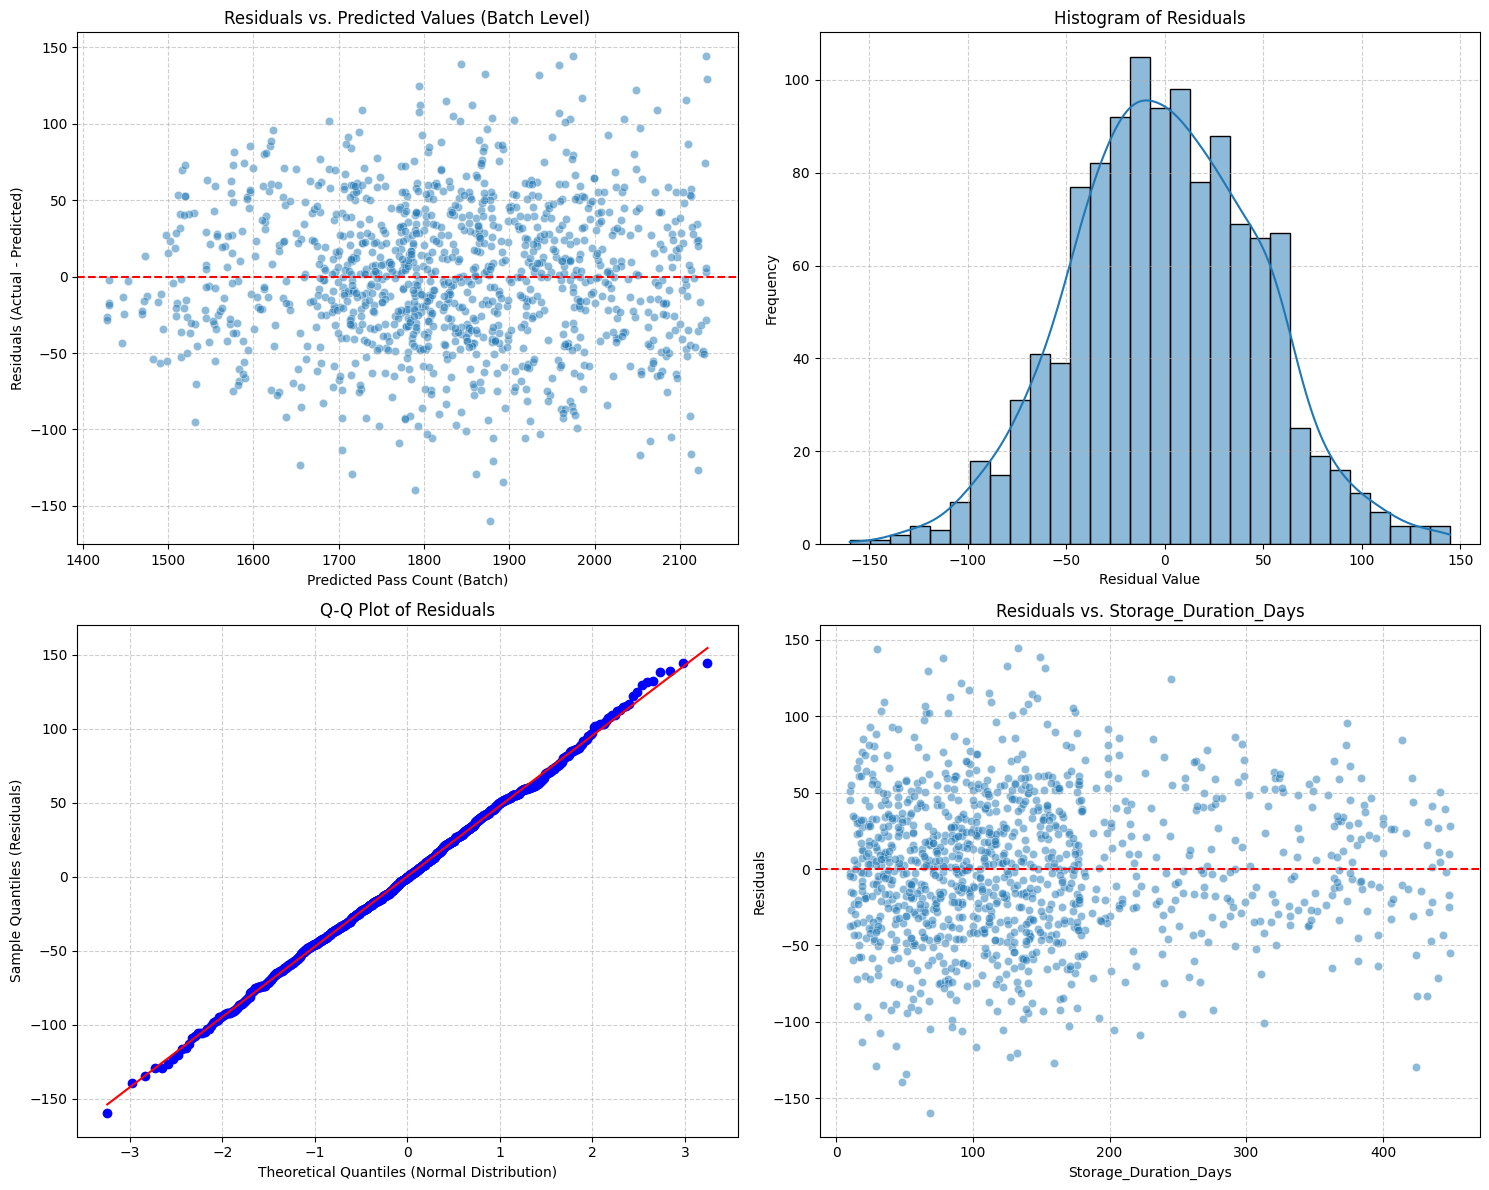

In [18]:
# Stage 7: Residual Analysis for Tuned Batch-Level Random Forest Model (Corrected)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats # For Q-Q plot

print("\n--- Performing Residual Analysis on Tuned Batch-Level Predictions ---")

# --- Prerequisites: Ensure necessary variables exist ---
# y_test: Actual batch pass counts for the test set (Pandas Series with index)
# y_pred_batch_tuned: Predicted batch pass counts (NumPy array from model.predict)
# test_batch_df: DataFrame containing ORIGINAL features AND Lot_ID for test set batches (index aligned with y_test)

required_vars = ['y_test', 'y_pred_batch_tuned', 'test_batch_df']
for var_name in required_vars:
    if var_name not in locals():
        raise NameError(f"Required variable '{var_name}' not found. Ensure previous cells (Data Prep & Model Fit) ran correctly.")

if len(y_test) != len(y_pred_batch_tuned):
     raise ValueError("Length mismatch between y_test and y_pred_batch_tuned.")
if not isinstance(test_batch_df, pd.DataFrame):
    raise TypeError("'test_batch_df' should be a DataFrame containing original test features.")
# Ensure y_test index is aligned with test_batch_df index before creating y_pred_series
if not test_batch_df.index.equals(y_test.index):
    print("Warning: Index mismatch between test_batch_df and y_test. Attempting alignment.")
    try:
        y_test = y_test.loc[test_batch_df.index]
    except Exception as e:
        raise IndexError(f"Could not align y_test index with test_batch_df index: {e}")


# --- Calculate Residuals ---
# Convert prediction array to Series using y_test's index for alignment
y_pred_series = pd.Series(y_pred_batch_tuned, index=y_test.index, name="Predicted_Batch_Pass")
residuals = y_test - y_pred_series

print(f"\nResiduals calculated for {len(residuals)} test batch samples.")
print("Residuals Summary Statistics:")
print(residuals.describe())


# --- Create Residual Plots ---
print("\nGenerating Residual Plots...")
plt.figure(figsize=(15, 12))

# 1. Residuals vs. Predicted Values
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_pred_series, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values (Batch Level)')
plt.xlabel('Predicted Pass Count (Batch)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.6)

# 2. Histogram of Residuals
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)

# 3. Q-Q Plot of Residuals
plt.subplot(2, 2, 3)
stats.probplot(residuals.dropna(), dist="norm", plot=plt) # Drop potential NaNs in residuals
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Sample Quantiles (Residuals)')
plt.grid(True, linestyle='--', alpha=0.6)


# 4. Residuals vs. Key Feature (Storage_Duration_Days)
# *** Use test_batch_df which contains the original, unencoded features ***
feature_to_plot = 'Storage_Duration_Days'
plt.subplot(2, 2, 4)
if feature_to_plot in test_batch_df.columns:
     # Use the index from residuals (which matches y_test/test_batch_df) to select aligned feature values
     sns.scatterplot(x=test_batch_df.loc[residuals.index, feature_to_plot], y=residuals, alpha=0.5)
     plt.axhline(0, color='red', linestyle='--')
     plt.title(f'Residuals vs. {feature_to_plot}')
     plt.xlabel(feature_to_plot)
     plt.ylabel('Residuals')
     plt.grid(True, linestyle='--', alpha=0.6)
else:
     # Add placeholder text if column not found
     plt.text(0.5, 0.5, f'Plot failed:\n\'{feature_to_plot}\' column not found\nin test_batch_df.',
              ha='center', va='center', transform=plt.gca().transAxes)
     print(f"\nSkipping Residuals vs {feature_to_plot} plot: Column not available in test_batch_df.")


plt.tight_layout()
plt.show()


## 7. Residual Analysis Interpretation

The residual plots and statistics help validate the performance of the tuned Random Forest model trained on batch-level data:

1.  **Residuals vs. Predicted Values:** The scatter plot showed points forming a **random cloud around the horizontal line at zero**. This is a good indication that the model errors are generally unbiased and do not systematically increase or decrease with the magnitude of the prediction (i.e., no obvious heteroscedasticity related to the predicted value).
2.  **Distribution of Residuals:** The **histogram appeared roughly bell-shaped**, and the points on the **Q-Q plot generally followed the diagonal line**. This suggests that the residuals are approximately normally distributed, which is often a sign of a well-fitting model (although less strictly required for Random Forest compared to linear regression). The summary statistics confirm this, showing a **mean residual very close to zero (0.356)**, indicating no significant overall bias in the predictions. The standard deviation of the residuals (~47.5 lenses) gives a measure of the typical error spread.
3.  **Residuals vs. Storage Duration:** A pattern was observed here, specifically a **dense packing of points for batches with less than ~180 days** of storage. Given that the Residuals vs. Predicted plot showed random scatter around zero overall, this density likely **reflects the underlying distribution of the input data** (where most batches had shorter storage times in the simulation) rather than a strong systematic error pattern. While there might be subtle effects of storage duration not perfectly captured, the errors appear reasonably distributed around zero across the storage range, suggesting the model captured the primary impact of this crucial feature.

**Overall Conclusion from Residuals:** The residual analysis does not reveal major systematic errors, non-linearities, or heteroscedasticity missed by the model. The errors appear reasonably random and centered around zero, supporting the validity of the model and the high R-squared score (0.927) achieved on the test set. There are no obvious signs of data leakage indicated by these plots.`

## 8. Conclusion & Next Steps

**Conclusion:**

This project successfully developed a high-accuracy machine learning model (Tuned Random Forest, R²≈0.93) for predicting the total output count of contact lens production lots prior to delensing. The analysis demonstrated that:
* Modeling at the granular batch level and aggregating predictions provides significantly better accuracy than modeling directly on aggregated lot-level features.
* Key drivers influencing batch output (and therefore lot output) include the initial mould count, pre-delensing storage duration, whether the lens power falls within a specific low range, and upstream quality control results.

**Business Impact:**

The resulting model provides a tool that can enable more accurate planning for order fulfillment by predicting lot output based on the characteristics of the input batches (especially their storage age). This can lead to better inventory management and potentially reduced costs associated with planning errors.

**Limitations:**

* The analysis was performed on **simulated data**. Validation on real historical production data is essential.
* The simulation simplifies real-world complexities and noise.
* Hyperparameter tuning was performed using `RandomizedSearchCV` but was not exhaustive.

**Future Work:**

* Acquire and preprocess real production data to validate the model and findings.
* Perform more extensive hyperparameter tuning (e.g., using GridSearchCV or more iterations of RandomizedSearch).
* Explore other potentially powerful models like Gradient Boosting (XGBoost, LightGBM).
* Investigate incorporating additional features if available (e.g., detailed environmental data, specific machine maintenance logs).
* Explore the feasibility of deploying the model as part of a production planning or inventory management tool.